## What is the most optimal skill to learn for Data Analysts?

### Steps

1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. Determine if certain technologies are more prevalent

In [1]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt 
import seaborn as sns 

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x:ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
df_DA_IN = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'India')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_IN = df_DA_IN.dropna(subset=['salary_year_avg'])

df_DA_IN_exploded = df_DA_IN.explode('job_skills')

df_DA_IN_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
11412,50400.0,python
11412,50400.0,sql
11412,50400.0,aws
11412,50400.0,azure
11412,50400.0,excel


In [3]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_IN_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_IN)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,46,96050.0,48.936170
excel,39,98500.0,41.489362
python,36,96050.0,38.297872
tableau,20,108087.5,21.276596
r,18,79200.0,19.148936
...,...,...,...
postgresql,1,165000.0,1.063830
ms access,1,64600.0,1.063830
mysql,1,165000.0,1.063830


#### Median Salary vs Percent Skill Demand

* Filters for Data Analyst skills that exceed a certain percentage (skill_limit).

In [8]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

#### Plotting

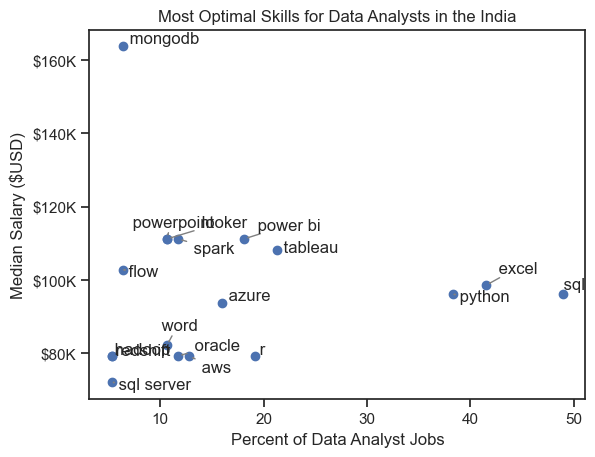

In [17]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary ($USD)')  # Assuming this is the label you want for y-axis
plt.title('Most Optimal Skills for Data Analysts in the India')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))


plt.show()


In [10]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [11]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology


,technology,skills
0,analyst_tools,powerbi
0,analyst_tools,microstrategy
0,analyst_tools,spss
0,analyst_tools,outlook
0,analyst_tools,powerpoint
...,...,...
9,sync,wire
9,sync,zoom
9,sync,slack
9,sync,symphony


In [12]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,46,96050.0,48.936170,programming,sql
1,39,98500.0,41.489362,analyst_tools,excel
2,36,96050.0,38.297872,programming,python
3,20,108087.5,21.276596,analyst_tools,tableau
4,18,79200.0,19.148936,programming,r
...,...,...,...,...,...
80,1,165000.0,1.063830,databases,postgresql
81,1,64600.0,1.063830,analyst_tools,ms access
82,1,165000.0,1.063830,databases,mysql
83,1,163782.0,1.063830,databases,neo4j


In [13]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

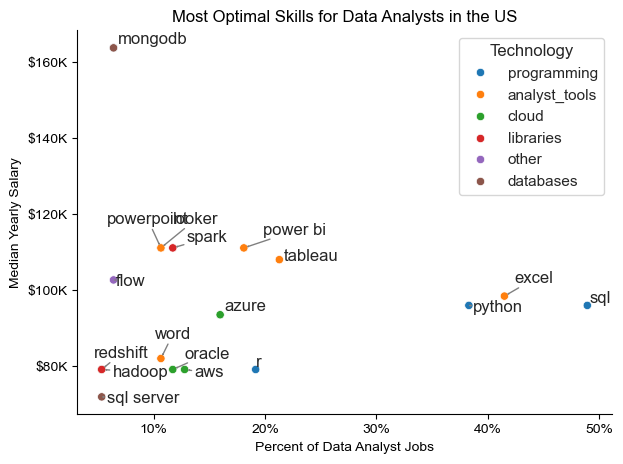

In [14]:
sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.legend(title='Technology')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display plot 
plt.tight_layout()
plt.show()